## Clasificación de erupciones volcánicas: Random Forest Classifier

Para resolver el caso empezamos importando las librerías de pyhton necesarias para el tratamiento de los datos:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

A continuación cargamos los datos desde el archivo jm_train.csv que descargamos del sitio web de NUWE:

In [2]:
erupciones = pd.read_csv('jm_train.csv')
erupciones.sample(n=10, random_state=7) # muestra aleatoria de 10 filas

,feature1,feature2,feature3,feature4,feature5,feature6,target
374,1.632028,0.379189,0.653156,-0.432931,0.798642,0.528039,4
1831,-0.950817,1.826780,1.079688,0.982139,0.965271,0.280789,3
1729,-0.280237,-0.574079,0.343444,0.279612,0.047335,0.430280,3
1077,0.762876,-1.250818,-0.265368,-0.524067,-0.318830,0.191176,4
658,-1.591520,1.839367,1.451675,0.816453,1.370762,0.269947,3
817,0.003428,-1.180619,-1.776693,1.147069,-2.287533,-0.252131,2
1252,-0.959668,4.416567,1.901456,0.206116,2.609892,-0.325623,3
574,-0.946205,1.804720,-1.097666,-2.330333,0.484816,-2.450131,0
1306,-2.314010,2.418052,-0.474754,-0.977939,0.623891,-2.035774,2
200,-1.089726,0.194067,1.327640,-2.685586,2.339076,-0.657338,4


### Análisis descriptivo de los datos

In [3]:
erupciones.describe().T

,count,mean,std,min,25%,50%,75%,max
feature1,2100.0,-0.204656,1.543613,-6.683655,-1.171340,-0.443868,0.890023,4.565547
feature2,2100.0,0.199249,1.614024,-5.383371,-0.877386,0.320507,1.321430,6.700133
feature3,2100.0,-0.378140,1.450548,-6.147055,-1.365990,-0.439745,0.662898,4.157518
feature4,2100.0,-0.206425,1.442225,-5.653594,-1.259403,-0.176504,0.866879,4.371912
feature5,2100.0,-0.186419,1.501573,-5.912521,-1.211685,-0.195751,0.851843,5.068783
feature6,2100.0,-0.433229,1.188791,-4.433189,-1.131944,-0.406754,0.348593,4.016324
target,2100.0,1.980476,1.410537,0.000000,1.000000,2.000000,3.000000,4.000000


In [4]:
erupciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


In [5]:
print(f'Numero de NaNs: {erupciones.isnull().sum().sum()}')

Numero de NaNs: 0


In [6]:
print(f'Numero de filas duplicadas: {erupciones.duplicated().sum()}')

Numero de filas duplicadas: 0


Hay 6 variables numéricas  independientes o features que corresponden a las lecturas de cada sensor, y una variable dependiente o target que clasifica el tipo  de erupción en función de estas lecturas.

Los valores de los features estan en la misma escala, en el rango (-7; 7) aprox por lo que no haría falta escalar. Tienen media y desvio estandar similares.

Los datos parecen estar bastante "limpios y ordenados", no hay NaN's ni filas duplicadas en las 2100 filas que tiene el dataset.

Con respecto a la variable target:

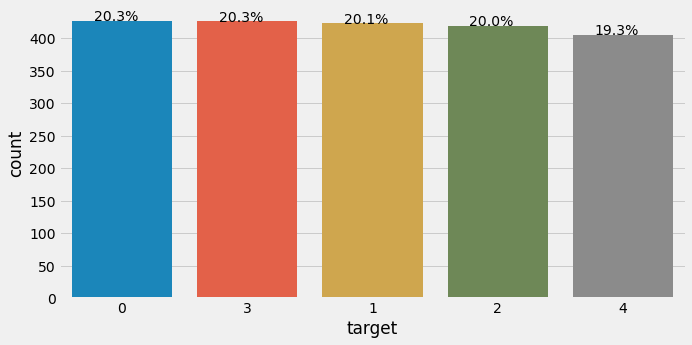

In [7]:
plt.figure(figsize = (10,5))
ax = sns.countplot(data=erupciones, x='target', order=erupciones.target.value_counts().index)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(erupciones))
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plt.annotate(percentage, (x, y),ha='center')
plt.show()

In [8]:
erupciones.target.value_counts()*100/erupciones.target.value_counts().sum()

0    20.333333
3    20.285714
1    20.142857
2    19.952381
4    19.285714
Name: target, dtype: float64

La variable target esta equilibrada entre las distintas clases, tenemos un ~20% de cada uno de los casos.

Separaremos en un dataframe la variable target del resto de los features y analizaremos como se comportan unos y otros:

In [9]:
x = erupciones.drop(['target'], axis='columns')
y = pd.DataFrame(erupciones.target)

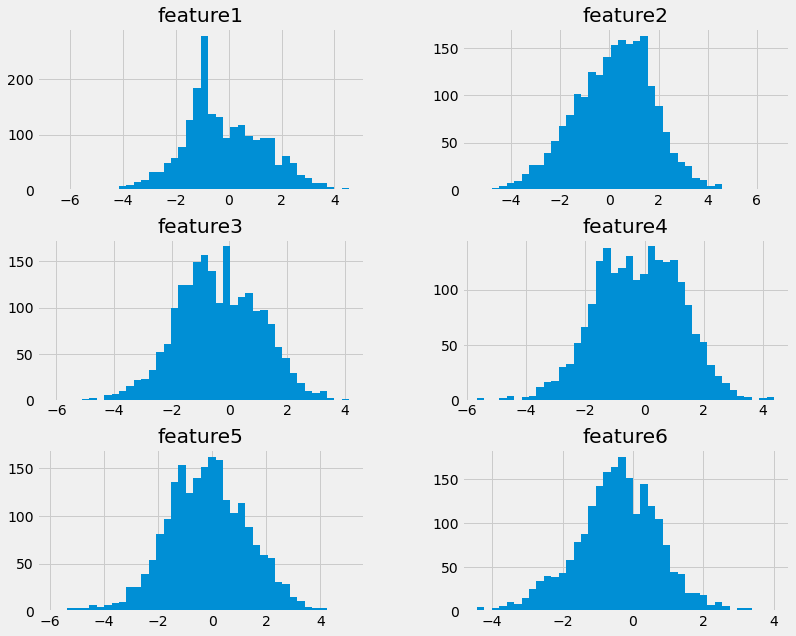

In [10]:
x.hist(bins=40, figsize=(12, 10))
plt.show()

Como habiamos dicho previamente, las variables independientes tienen su valor medio en 0 y parecen seguir una distribución normal.

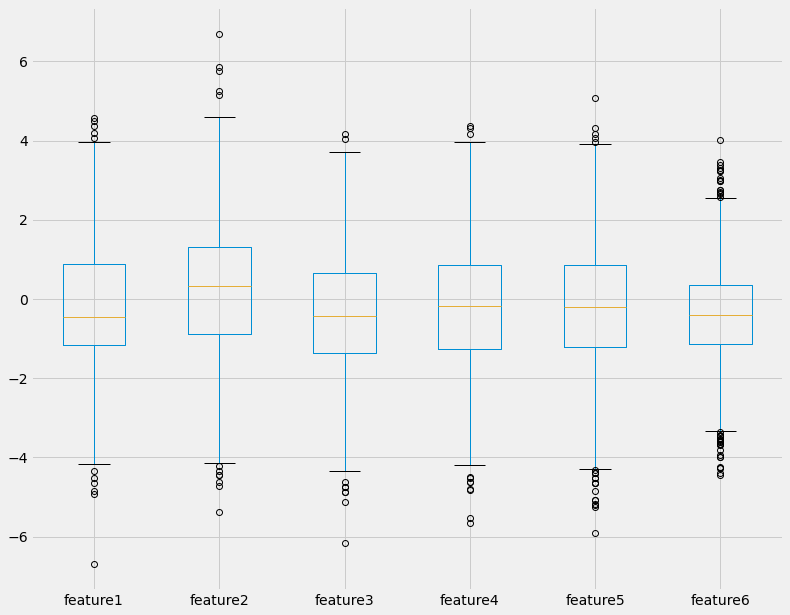

In [11]:
plt.figure(figsize = (12,10))
x.boxplot()
plt.show()

No parece que haya un problema de outliers o valores atipicos ya que interpreto que son valores posibles de lectura de los sensores (true outliers).

Veamos a continuación como se correlacionan las variables entre si:

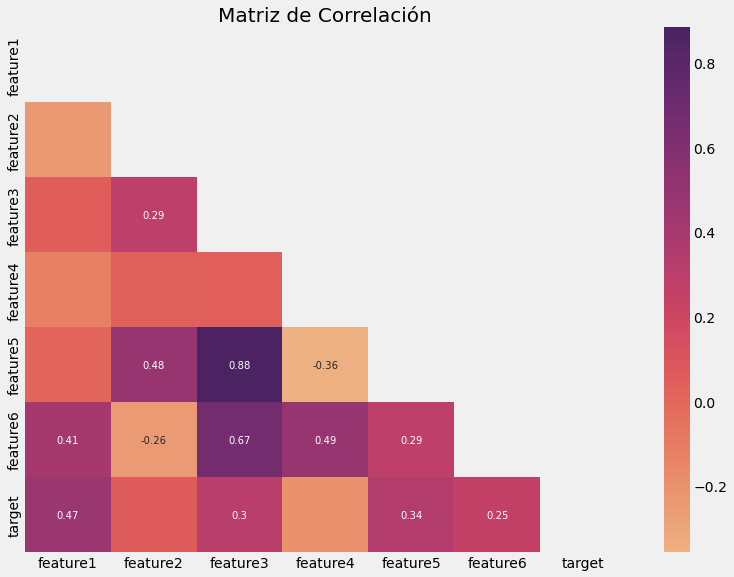

In [12]:
erupciones_corr = erupciones.corr()

mask = np.triu(np.ones_like(erupciones_corr, dtype = bool)) # mask the upper triangle, easier to read
fig, ax = plt.subplots(figsize = (12, 9))

sns.heatmap(erupciones_corr, mask = mask, cmap = 'flare', annot = True, annot_kws = {"size": 10})

for t in ax.texts:
    if float(t.get_text()) >= 0.25: # if the value is greater than 0.1 then I set the text 
        t.set_text(t.get_text()) 
    elif float(t.get_text()) <= -0.25: # if the value is smaller than -0.1 then I set the text 
        t.set_text(t.get_text())
    else:
        t.set_text("") # if not it sets an empty text

plt.title('Matriz de Correlación', fontsize = 20)
plt.show()

El feature1 es el que presenta mayor correlación lineal de Pearson con el target, con un 0,47 positivo. De todas maneras se puede considerar correlación media-baja. 

Por otro lado el feature3 presenta una correlación media positiva con el feature6 y media-alta positiva con el feature5 lo cual nos podría llegar a dar problemas de multicolinealidad o sobre ajuste.

### Modelizado de los datos

Primero dividimos la muestra entre datos para entrenamiento y datos para evaluación y obtención de metricas de performance del modelo:

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=7)  # 80%-20% proportion

In [14]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1575, 6), (525, 6), (1575, 1), (525, 1))

Utilizamos el algoritmo de Random Forest Classifier para multiclases con los parametros por defecto:

In [15]:
from sklearn.ensemble import RandomForestClassifier

#instantiate RandomForestClassifier()
model = RandomForestClassifier(random_state=7)


#fit the classification
model.fit(x_train, np.ravel(y_train))

#Predict on test
y_pred = model.predict(x_test)

Matriz de confusión

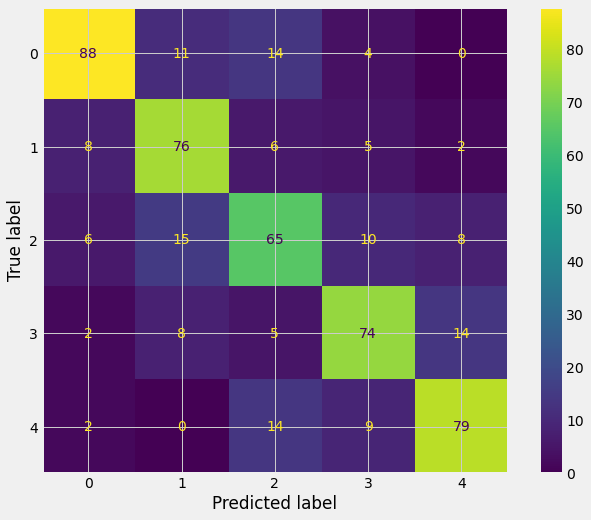

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

plt.show()

In [17]:
from sklearn.metrics import accuracy_score,f1_score,classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       117
           1       0.69      0.78      0.73        97
           2       0.62      0.62      0.62       104
           3       0.73      0.72      0.72       103
           4       0.77      0.76      0.76       104

    accuracy                           0.73       525
   macro avg       0.73      0.73      0.73       525
weighted avg       0.73      0.73      0.73       525



In [18]:
round(f1_score(y_test, y_pred, average='macro'),2)

0.73

El modelo arroja un f1_score (macro) de 0,73 lo cual no esta mal. Veremos si podemos obtener mejores metricas ajustando los parámetros:

In [19]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro') # metrica a optimizar

In [20]:
from sklearn.model_selection import GridSearchCV

# Parameters combination (Random Forest)
parameters = {"n_estimators": [100, 300, 500], "min_samples_leaf": [1, 10, 20], 'max_depth': [None, 10, 30], 
              "min_samples_split": [2, 5, 10], "criterion":["entropy","gini"], "bootstrap": [True, False]}

# create and instantiate grid search
grid = GridSearchCV(model, parameters, cv=5, scoring=f1) # 5 splits cross validation

#fit the model
grid.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=7),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 10, 30],
                         'min_samples_leaf': [1, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             scoring=make_scorer(f1_score, average=macro))

In [21]:
print(f'Best parameters combination: {grid.best_params_}')

Best parameters combination: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [22]:
#instantiate RandomForestClassifier()
model2 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=1, min_samples_split=2, 
                                bootstrap=True, criterion='gini')

#fit the classification
model2.fit(x_train, np.ravel(y_train))

#Predict on test
y_pred2 = model2.predict(x_test)

In [23]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       117
           1       0.69      0.77      0.73        97
           2       0.65      0.64      0.65       104
           3       0.75      0.75      0.75       103
           4       0.78      0.81      0.79       104

    accuracy                           0.74       525
   macro avg       0.74      0.74      0.74       525
weighted avg       0.74      0.74      0.74       525



In [24]:
round(f1_score(y_test, y_pred2, average='macro'),2)

0.74

Hemos obtenido 0,74 en el f1_score por lo tanto el ajuste de parametros ha reportado una leve mejoría.

Hare una prueba ahora aplicando algunas tecnicas de ingeniería de variables:

In [25]:
erupciones1 = erupciones # hago una copia para no modificar el dataframe original

Eliminamos los outliers:

In [26]:
from collections import Counter

#drop the label 
outlier_list = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6'] 

def detect_outlier(df,feature):
    
    outlier_indices = []
    
    for f in feature:
        
        #lower quartile
        q1 = np.percentile(df[f],25)
        
        #upper quartile
        q3 = np.percentile(df[f],75)
        
        #interquartile range
        iqr = q3-q1
        
        #with coefficient
        with_coef = 1.5*iqr
        
        #detect outlier(s)
        lower_rule = q1-with_coef
        upper_rule = q3+with_coef
        
        outlier_variable = df[(df[f]<lower_rule) | (df[f]>upper_rule)].index
        outlier_indices.extend(outlier_variable)
    
    #converting to amount
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i,v in outlier_indices.items() if v>2)
    
    return multiple_outliers

 
#drop outliers
erupciones1 = erupciones1.drop(detect_outlier(erupciones1, outlier_list), axis=0).reset_index(drop=True)

In [27]:
erupciones1.shape

(2098, 7)

Solo se han eliminado 2 filas. Ahora normalizaremos las variables y luego haremos relaciones polinomicas:

In [28]:
x1 = erupciones1.drop(['target'], axis='columns')
y1 = pd.DataFrame(erupciones1.target)

In [29]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4)
x1 = poly.fit_transform(x1)
x1 = pd.DataFrame(data=x1)

x1.shape

(2098, 210)

In [30]:
from sklearn.preprocessing import MinMaxScaler

x1= pd.DataFrame(MinMaxScaler().fit_transform(x1))

In [31]:
# from sklearn.decomposition import PCA

# pca = PCA(.95) #95% of the variance is retained
# x1 = pca.fit_transform(x1)
# x1 = pd.DataFrame(data=x1)

In [32]:
# pca_expl = pca.explained_variance_ratio_.round(3) # how much variance exlains each PCA column
# pca_expl

In [33]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.25, random_state=7)

In [34]:
#instantiate RandomForestClassifier()
model3 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=1, min_samples_split=2, 
                                bootstrap=True, criterion='gini')

#fit the classification
model3.fit(x_train1, np.ravel(y_train1))

#Predict on test
y_pred3 = model3.predict(x_test1)

In [35]:
round(f1_score(y_test1, y_pred3, average='macro'),2)

0.74

Luego de probar con diferentes técnicas de ingenieria de variables (feature engineer) no se consigue aumentar el f1_score.

Finalmente haremos la clasificación de los datos presentes en el archivo jm_X_test.cvs y la guardaremos en el archivo test_pred.csv:

In [36]:
erupciones_predict = pd.read_csv('jm_X_test.csv')

In [39]:
erupciones_predict_pred = model2.predict(erupciones_predict)

In [40]:
pd.DataFrame(erupciones_predict_pred, columns=['test_predicted']).to_csv("test_pred.csv", index=None)